In [ ]:
# Date    :   2024-12-01
# Author  :   Dongwoo Yoon
# Contact :   dbsehddn0901@gmail.com


# 라이브러리 import

In [23]:
from google.colab import files
import os
import pandas as pd
from glob import glob
import torch
import random
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
from collections import Counter

# 데이터셋 로드

In [ ]:
!pip install kaggle

In [ ]:
# upload kaggle.json
files.upload()

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [5]:
# download datasets
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 99% 329M/331M [00:13<00:00, 32.8MB/s]
100% 331M/331M [00:13<00:00, 24.9MB/s]


In [ ]:
!unzip utkface-new.zip

In [54]:
folder_name = 'UTKFace'

file_mapping = {
    "UTKFace/61_1_20170109142408075.jpg.chip.jpg": "UTKFace/61_1_1_20170109142408075.jpg.chip.jpg",
    "UTKFace/39_1_20170116174525125.jpg.chip.jpg": "UTKFace/39_0_1_20170116174525125.jpg.chip.jpg",
    "UTKFace/61_1_20170109150557335.jpg.chip.jpg": "UTKFace/61_1_3_20170109150557335.jpg.chip.jpg"
}

def parse_dataset(dataset_path, ext='jpg'):
    def parse_info_from_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, _, _ = filename.split('_')

            '''
              binning the age
              80 ~ 89 -> 80
              90+     -> 90
            '''
            if int(age) // 10 == 8:
                age = 79
            elif int(age) // 10 >= 9:
                age = 80
            else:
                age = int(age) - 1

            return age, int(gender)
        except Exception as ex:
            return None, None

    files = glob(os.path.join(dataset_path, "*.%s" % ext))

    records = []
    for file in files:

        if file in file_mapping:
            file = file_mapping[file]

        info = parse_info_from_file(file)
        if info[0] is not None:
            records.append(info)
        else:
          print(file)

    df = pd.DataFrame(records)

    df['file'] = files[:len(records)]
    df.columns = ['age', 'gender', 'file']
    df = df.dropna()

    return df

df = parse_dataset(folder_name)

print(df.head())

   age  gender                                           file
0   15       0  UTKFace/16_0_0_20170110232444834.jpg.chip.jpg
1   19       1  UTKFace/20_1_1_20170112231738487.jpg.chip.jpg
2   51       0  UTKFace/52_0_3_20170119200211340.jpg.chip.jpg
3    2       0   UTKFace/3_0_2_20161219160259510.jpg.chip.jpg
4   34       0  UTKFace/35_0_0_20170116193236930.jpg.chip.jpg


In [55]:
number_of_age_classes = len(df['age'].unique())
print(number_of_age_classes)

81


# GPU 환경

In [36]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

!nvidia-smi

True
1
Mon Dec  2 03:25:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              32W /  70W |   6487MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------------------

# 랜덤시드 고정

In [37]:
def seed_everything(seed):
    random.seed(seed)  # Python
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch
    torch.cuda.manual_seed(seed)  # PyTorch cuda
    torch.backends.cudnn.deterministic = True  # CuDNN
    torch.backends.cudnn.benchmark = False  # CuDNN benchmark

In [38]:
seed_everything(seed=32)

# Train / Valid / Test 데이터셋 분리

- UTKFace 데이터는 train, valid, test 데이터셋 구분이 없어 분리 필요

- Ratio
      train : valid : test = 7 : 2 : 1

In [12]:
stratify_array = np.array(list(zip(df['age'], df['gender'])))

# df -> 70% train_df, 30% temp_df
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,  # 30% temp_df
    random_state=0,
    shuffle=True,
    stratify=stratify_array,
)

temp_stratify_array = np.array(list(zip(temp_df['age'], temp_df['gender'])))

# temp_df -> valid_df, test_df (2:1)
valid_df, test_df = train_test_split(
    temp_df,
    test_size=1/3,  # 1/3 test_df
    random_state=0,
    shuffle=True,
    stratify=temp_stratify_array,
)

# print result
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")


Train set size: 16595
Validation set size: 4742
Test set size: 2371


# DataSet, DataLoader 생성


In [39]:
# 사용자 정의 데이터셋 클래스 생성 (CustomDataset)
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # 데이터셋 초기화
        # dataframe: 이미지 경로와 age, gender가 포함된 데이터프레임
        # transform: 이미지에 적용할 전처리(transform) 함수
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플을 반환
        # 이미지 경로를 데이터프레임에서 가져옴
        img_name = self.dataframe.iloc[idx, 2]
        # 이미지 파일을 열고 RGB 모드로 변환
        img = Image.open(img_name).convert('RGB')
        # age와 gender 정보를 정수형으로 가져옴
        age = int(self.dataframe.iloc[idx, 0])
        gender = int(self.dataframe.iloc[idx, 1])

        # transform이 지정되어 있다면 이미지에 전처리를 적용
        if self.transform:
            img = self.transform(img)

        # 이미지와 age, gender를 반환
        return img, age, gender


In [40]:
# 이미지 전처리를 위한 변환 작업 정의
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Lambda(lambda x: x / 255.0)  # 255로 나누어 [0, 1] 범위로 변환
])

# 데이터셋 로딩
train_dataset = CustomDataset(dataframe=train_df, transform=transform)
valid_dataset = CustomDataset(dataframe=valid_df, transform=transform)
test_dataset = CustomDataset(dataframe=test_df, transform=transform)

batch_size = 128

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ResNet 모델 학습


In [41]:
# 사전 학습된 ResNet18 모델 불러오기
model = models.resnet18(pretrained=True)

# 모델의 마지막 완전 연결 계층(fc)을 사용자 정의 계층으로 대체
# 중간 레이어
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 128),  # 중간 레이어
    nn.ReLU(),
    nn.Dropout(0.5)
)

# 성별 출력 (2개 클래스)
gender_output = nn.Linear(128, 2)  # 성별 출력
# 나이 출력 (81개 클래스)
age_output = nn.Linear(128, number_of_age_classes)     # 나이 출력

# 모델에 출력 레이어 추가
model.gender_output = gender_output
model.age_output = age_output

# 교차 엔트로피 손실 함수 초기화
criterion_gender = nn.CrossEntropyLoss()  # 성별 출력에 대한 손실
criterion_age = nn.CrossEntropyLoss()      # 나이 출력에 대한 손실

# 최적화 알고리즘으로 Adam 사용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [42]:
# 학습 파라미터 설정
num_epochs = 50
best_val_acc = 0.0
patience = 5
no_improve = 0

# 훈련 및 검증 손실을 추적하기 위한 리스트
train_losses = []
valid_losses = []

# 훈련 및 검증 나이 Top-3 정확도 추적하기 위한 리스트
train_accs = []
valid_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_gender_train = 0
    correct_age_train_top3 = 0
    total_train = 0

    for inputs, ages, genders in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        inputs, ages, genders = inputs.to(device), ages.to(device), genders.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        # 모델의 출력
        gender_logits = model.gender_output(outputs)
        age_logits = model.age_output(outputs)

        # 손실 계산
        loss_gender = criterion_gender(gender_logits, genders)
        loss_age = criterion_age(age_logits, ages)
        loss = loss_gender + loss_age  # 총 손실

        # 역전파
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 성별 정확도 계산
        _, predicted_gender = torch.max(gender_logits, 1)
        correct_gender_train += (predicted_gender == genders).sum().item()

        # 나이 예측에 대한 Top-3 정확도 계산
        _, predicted_age_top3 = torch.topk(age_logits, k=3, dim=1)
        correct_age_train_top3 += sum([ages[i] in predicted_age_top3[i] for i in range(len(ages))])
        total_train += ages.size(0)

    # 평균 손실 및 정확도 계산
    avg_loss = running_loss / len(train_loader)
    train_acc_gender = correct_gender_train / total_train
    train_acc_age_top3 = correct_age_train_top3 / total_train

    # 검증 단계
    model.eval()
    correct_gender_val = 0
    correct_age_val_top3 = 0
    total_val = 0
    running_val_loss = 0.0

    with torch.no_grad():
        for inputs, ages, genders in valid_loader:
            inputs, ages, genders = inputs.to(device), ages.to(device), genders.to(device)

            outputs = model(inputs)
            gender_logits = model.gender_output(outputs)
            age_logits = model.age_output(outputs)

            # 손실 계산
            loss_gender = criterion_gender(gender_logits, genders)
            loss_age = criterion_age(age_logits, ages)
            val_loss = loss_gender + loss_age
            running_val_loss += val_loss.item()

            # 성별 정확도 계산
            _, predicted_gender = torch.max(gender_logits, 1)
            correct_gender_val += (predicted_gender == genders).sum().item()

            # 나이 예측에 대한 Top-3 정확도 계산
            _, predicted_age_top3 = torch.topk(age_logits, k=3, dim=1)
            correct_age_val_top3 += sum([ages[i] in predicted_age_top3[i] for i in range(len(ages))])
            total_val += ages.size(0)

    # 평균 검증 손실 및 정확도 계산
    avg_val_loss = running_val_loss / len(valid_loader)
    val_acc_gender = correct_gender_val / total_val
    val_acc_age_top3 = correct_age_val_top3 / total_val

    # 손실 기록
    train_losses.append(avg_loss)
    valid_losses.append(avg_val_loss)

    # 나이 Top-3 정확도 기록
    train_accs.append(train_acc_age_top3)
    valid_accs.append(val_acc_age_top3)

    # 학습 및 검증 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}]:")
    print(f"  Train Loss: {avg_loss:.4f}, Train Gender Acc: {train_acc_gender:.4f}, Train Age Top-3 Acc: {train_acc_age_top3:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Gender Acc: {val_acc_gender:.4f}, Val Age Top-3 Acc: {val_acc_age_top3:.4f}")

    # 조기 종료를 위한 정확도 비교 (Age Top-3 기준)
    if val_acc_age_top3 > best_val_acc:
        best_val_acc = val_acc_age_top3
        no_improve = 0
        # 모델 저장 코드 추가 가능
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/50: 100%|██████████| 130/130 [00:50<00:00,  2.56it/s]


Epoch [1/50]:
  Train Loss: 4.9459, Train Gender Acc: 0.6854, Train Age Top-3 Acc: 0.0898
  Val Loss: 4.7022, Val Gender Acc: 0.8142, Val Age Top-3 Acc: 0.1790


Epoch 2/50: 100%|██████████| 130/130 [00:49<00:00,  2.60it/s]


Epoch [2/50]:
  Train Loss: 4.6152, Train Gender Acc: 0.8292, Train Age Top-3 Acc: 0.1680
  Val Loss: 4.4053, Val Gender Acc: 0.8598, Val Age Top-3 Acc: 0.2138


Epoch 3/50: 100%|██████████| 130/130 [00:50<00:00,  2.59it/s]


Epoch [3/50]:
  Train Loss: 4.3873, Train Gender Acc: 0.8633, Train Age Top-3 Acc: 0.2002
  Val Loss: 4.1813, Val Gender Acc: 0.8762, Val Age Top-3 Acc: 0.2419


Epoch 4/50: 100%|██████████| 130/130 [00:50<00:00,  2.59it/s]


Epoch [4/50]:
  Train Loss: 4.2138, Train Gender Acc: 0.8847, Train Age Top-3 Acc: 0.2218
  Val Loss: 4.0502, Val Gender Acc: 0.8908, Val Age Top-3 Acc: 0.2493


Epoch 5/50: 100%|██████████| 130/130 [00:50<00:00,  2.59it/s]


Epoch [5/50]:
  Train Loss: 4.1045, Train Gender Acc: 0.9010, Train Age Top-3 Acc: 0.2410
  Val Loss: 3.9612, Val Gender Acc: 0.8998, Val Age Top-3 Acc: 0.2596


Epoch 6/50: 100%|██████████| 130/130 [00:50<00:00,  2.59it/s]


Epoch [6/50]:
  Train Loss: 4.0149, Train Gender Acc: 0.9130, Train Age Top-3 Acc: 0.2477
  Val Loss: 3.8907, Val Gender Acc: 0.9034, Val Age Top-3 Acc: 0.2718


Epoch 7/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [7/50]:
  Train Loss: 3.9277, Train Gender Acc: 0.9234, Train Age Top-3 Acc: 0.2607
  Val Loss: 3.8348, Val Gender Acc: 0.9085, Val Age Top-3 Acc: 0.2777


Epoch 8/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [8/50]:
  Train Loss: 3.8573, Train Gender Acc: 0.9290, Train Age Top-3 Acc: 0.2691
  Val Loss: 3.7876, Val Gender Acc: 0.9125, Val Age Top-3 Acc: 0.2900


Epoch 9/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [9/50]:
  Train Loss: 3.7738, Train Gender Acc: 0.9371, Train Age Top-3 Acc: 0.2818
  Val Loss: 3.7527, Val Gender Acc: 0.9135, Val Age Top-3 Acc: 0.2973


Epoch 10/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [10/50]:
  Train Loss: 3.7158, Train Gender Acc: 0.9454, Train Age Top-3 Acc: 0.2915
  Val Loss: 3.7137, Val Gender Acc: 0.9140, Val Age Top-3 Acc: 0.3018


Epoch 11/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [11/50]:
  Train Loss: 3.6560, Train Gender Acc: 0.9514, Train Age Top-3 Acc: 0.2962
  Val Loss: 3.6760, Val Gender Acc: 0.9135, Val Age Top-3 Acc: 0.3064


Epoch 12/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [12/50]:
  Train Loss: 3.5884, Train Gender Acc: 0.9572, Train Age Top-3 Acc: 0.3068
  Val Loss: 3.6553, Val Gender Acc: 0.9135, Val Age Top-3 Acc: 0.3119


Epoch 13/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [13/50]:
  Train Loss: 3.5269, Train Gender Acc: 0.9630, Train Age Top-3 Acc: 0.3157
  Val Loss: 3.6356, Val Gender Acc: 0.9129, Val Age Top-3 Acc: 0.3134


Epoch 14/50: 100%|██████████| 130/130 [00:50<00:00,  2.57it/s]


Epoch [14/50]:
  Train Loss: 3.4691, Train Gender Acc: 0.9673, Train Age Top-3 Acc: 0.3212
  Val Loss: 3.6194, Val Gender Acc: 0.9097, Val Age Top-3 Acc: 0.3159


Epoch 15/50: 100%|██████████| 130/130 [00:50<00:00,  2.59it/s]


Epoch [15/50]:
  Train Loss: 3.4202, Train Gender Acc: 0.9722, Train Age Top-3 Acc: 0.3290
  Val Loss: 3.6131, Val Gender Acc: 0.9116, Val Age Top-3 Acc: 0.3189


Epoch 16/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [16/50]:
  Train Loss: 3.3611, Train Gender Acc: 0.9751, Train Age Top-3 Acc: 0.3440
  Val Loss: 3.5976, Val Gender Acc: 0.9100, Val Age Top-3 Acc: 0.3243


Epoch 17/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [17/50]:
  Train Loss: 3.3041, Train Gender Acc: 0.9786, Train Age Top-3 Acc: 0.3502
  Val Loss: 3.5973, Val Gender Acc: 0.9085, Val Age Top-3 Acc: 0.3214


Epoch 18/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [18/50]:
  Train Loss: 3.2420, Train Gender Acc: 0.9827, Train Age Top-3 Acc: 0.3632
  Val Loss: 3.5912, Val Gender Acc: 0.9097, Val Age Top-3 Acc: 0.3286


Epoch 19/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [19/50]:
  Train Loss: 3.1963, Train Gender Acc: 0.9838, Train Age Top-3 Acc: 0.3715
  Val Loss: 3.5810, Val Gender Acc: 0.9108, Val Age Top-3 Acc: 0.3288


Epoch 20/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [20/50]:
  Train Loss: 3.1426, Train Gender Acc: 0.9863, Train Age Top-3 Acc: 0.3842
  Val Loss: 3.5836, Val Gender Acc: 0.9087, Val Age Top-3 Acc: 0.3292


Epoch 21/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [21/50]:
  Train Loss: 3.0855, Train Gender Acc: 0.9868, Train Age Top-3 Acc: 0.3983
  Val Loss: 3.5788, Val Gender Acc: 0.9066, Val Age Top-3 Acc: 0.3258


Epoch 22/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [22/50]:
  Train Loss: 3.0475, Train Gender Acc: 0.9882, Train Age Top-3 Acc: 0.4026
  Val Loss: 3.5795, Val Gender Acc: 0.9076, Val Age Top-3 Acc: 0.3292


Epoch 23/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [23/50]:
  Train Loss: 2.9900, Train Gender Acc: 0.9891, Train Age Top-3 Acc: 0.4174
  Val Loss: 3.5770, Val Gender Acc: 0.9057, Val Age Top-3 Acc: 0.3279


Epoch 24/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [24/50]:
  Train Loss: 2.9408, Train Gender Acc: 0.9895, Train Age Top-3 Acc: 0.4266
  Val Loss: 3.5771, Val Gender Acc: 0.9074, Val Age Top-3 Acc: 0.3264


Epoch 25/50: 100%|██████████| 130/130 [00:50<00:00,  2.58it/s]


Epoch [25/50]:
  Train Loss: 2.8985, Train Gender Acc: 0.9890, Train Age Top-3 Acc: 0.4420
  Val Loss: 3.5776, Val Gender Acc: 0.9064, Val Age Top-3 Acc: 0.3277
Early stopping triggered.


## Loss, Top-3 Accuracy 시각화


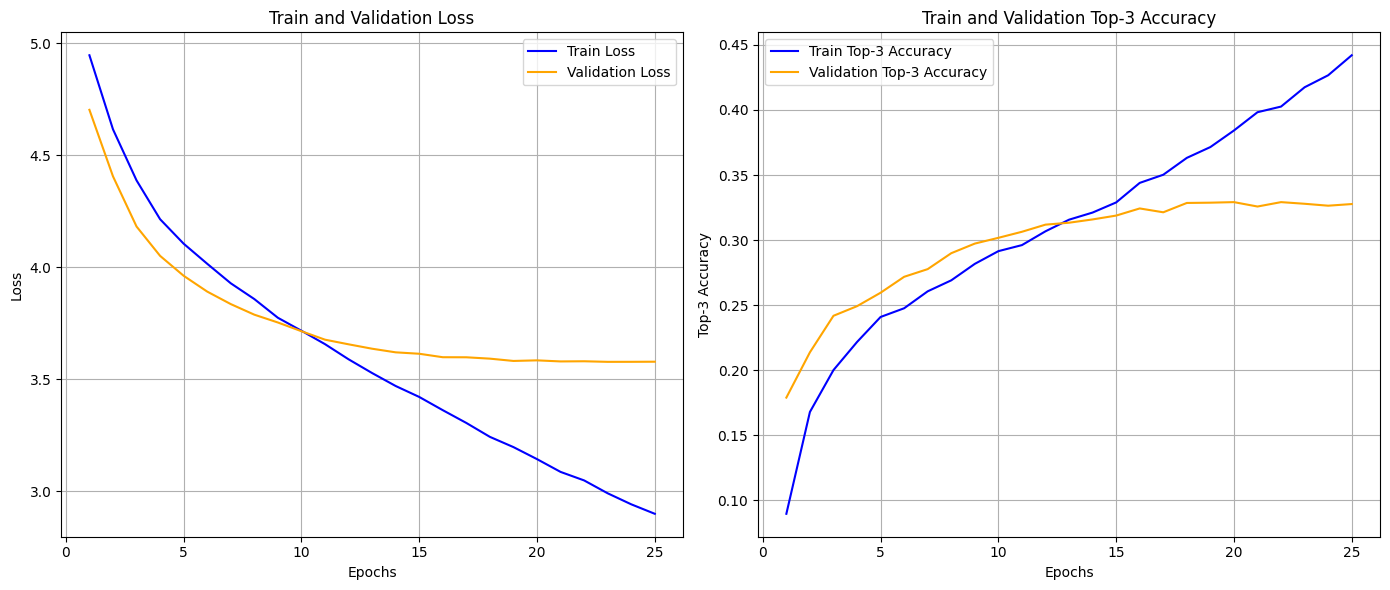

In [43]:
epochs = range(1, len(train_losses) + 1)

# 그래프 생성
plt.figure(figsize=(14, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color="blue")
plt.plot(epochs, valid_losses, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.grid(True)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Top-3 Accuracy", color="blue")
plt.plot(epochs, valid_accs, label="Validation Top-3 Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Top-3 Accuracy")
plt.title("Train and Validation Top-3 Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Data Augmentation #1


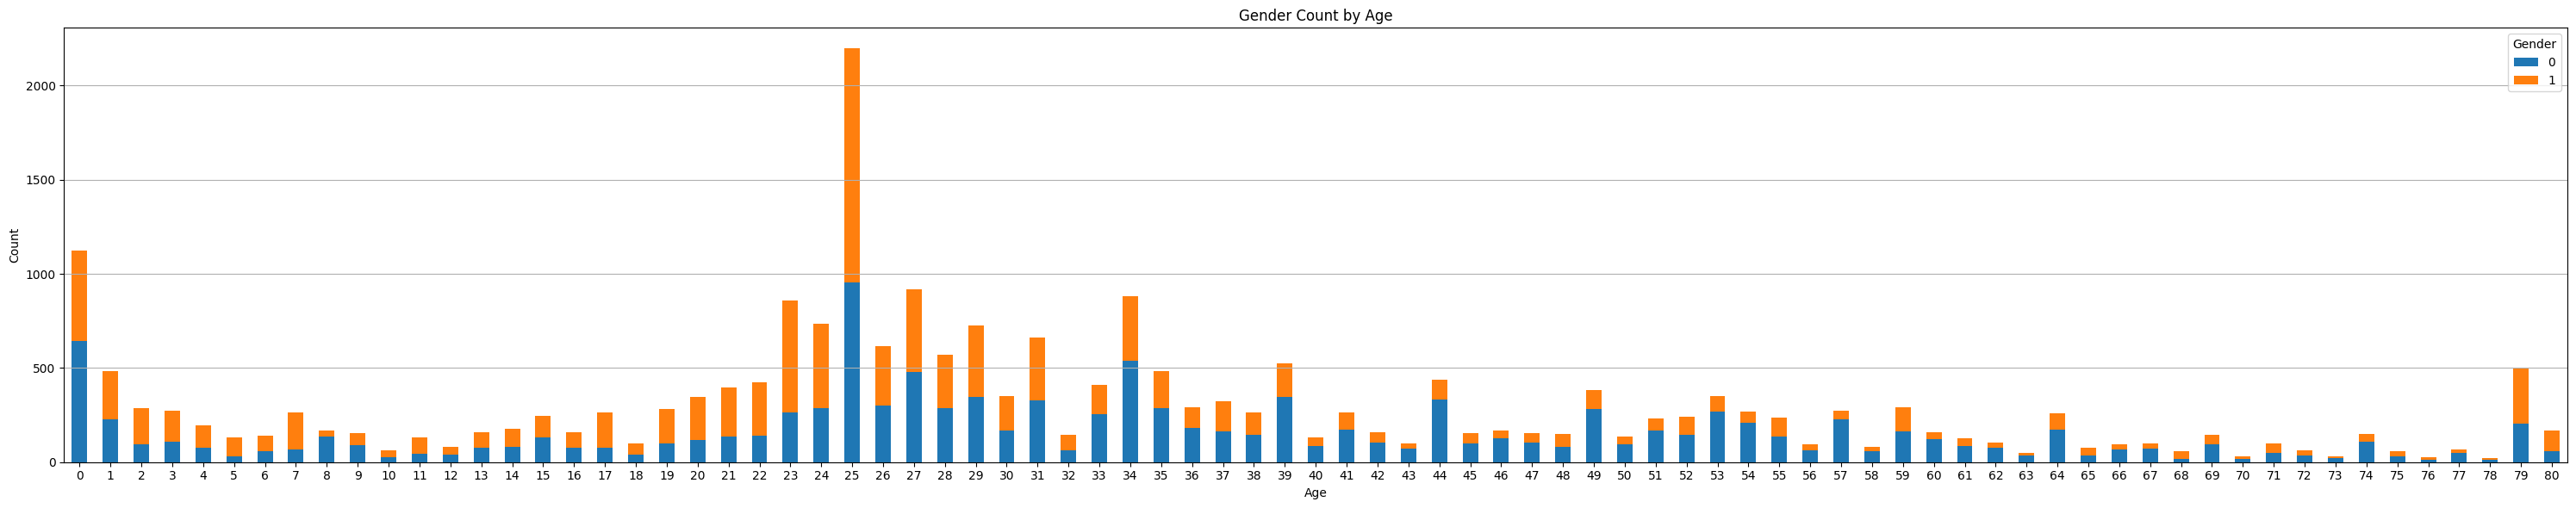

In [44]:
# Count the number of males and females by age
age_gender_counts = df.groupby(['age', 'gender']).size().unstack(fill_value=0)

# Plot the graph
age_gender_counts.plot(kind='bar', stacked=True, figsize=(30, 6))

# Set the title and labels
plt.title('Gender Count by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Gender')
plt.grid(axis='y')  # Add grid lines for better visualization

# Show the graph
plt.tight_layout()
plt.show()

## 언더 샘플링

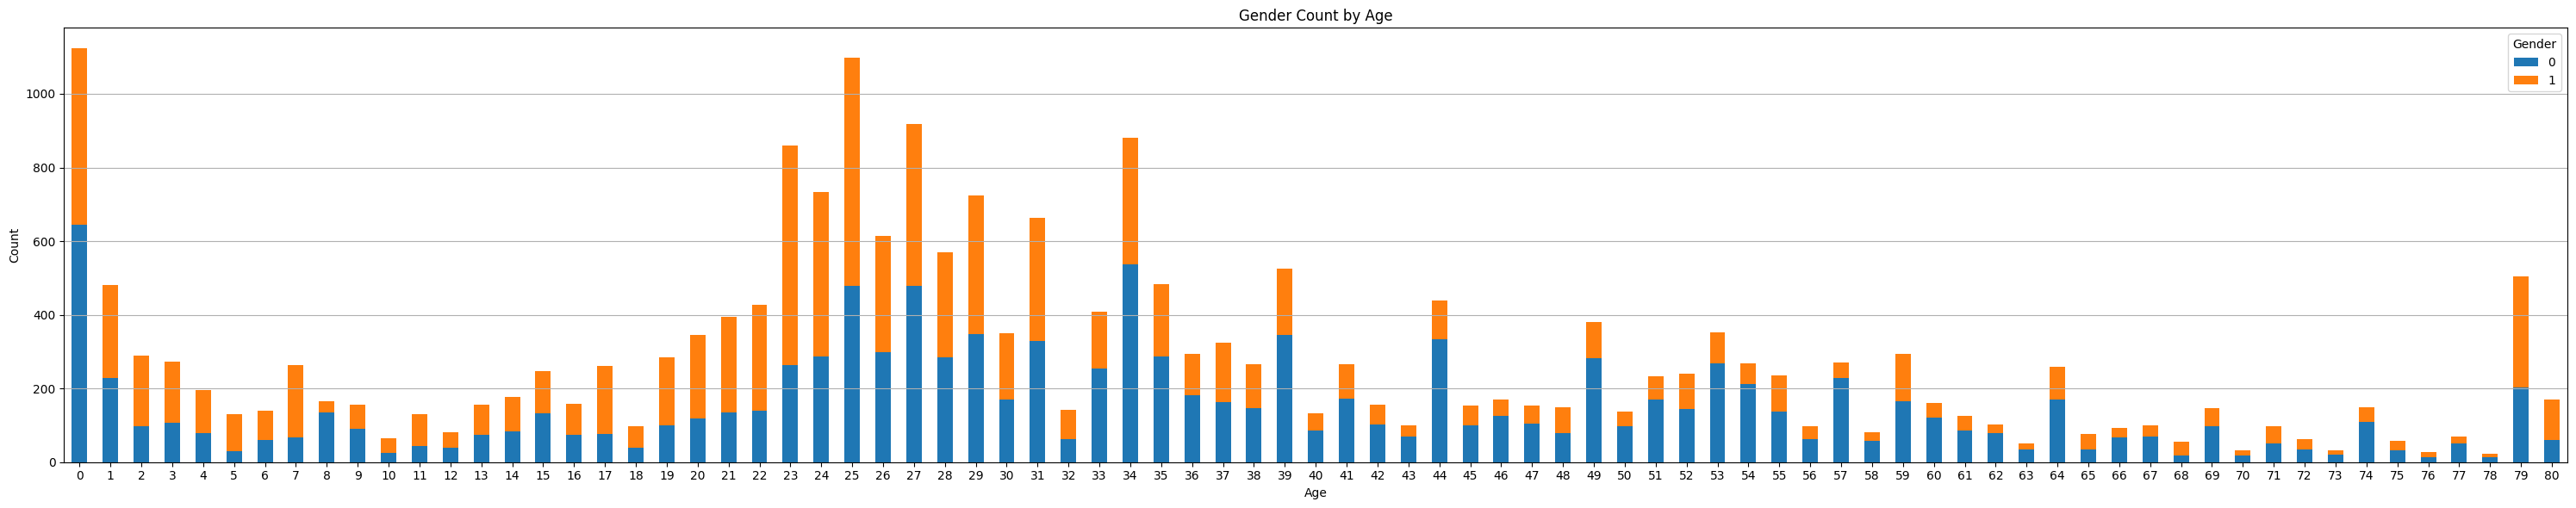

In [56]:
# age가 25인 데이터만 필터링
df_age_25 = df[df['age'] == 25]

# 성별로 나누기
df_male_25 = df_age_25[df_age_25['gender'] == 0]
df_female_25 = df_age_25[df_age_25['gender'] == 1]

# 각 성별에서 반으로 줄이기 (랜덤 샘플링)
df_male_25_reduced = df_male_25.sample(frac=0.5, random_state=42)  # 50% 샘플링
df_female_25_reduced = df_female_25.sample(frac=0.5, random_state=42)  # 50% 샘플링

# 남성, 여성 데이터를 합치기
df_reduced = pd.concat([df_male_25_reduced, df_female_25_reduced])

# 원본 df에서 age가 25인 데이터를 제외하고, 감소된 데이터를 합침
df = pd.concat([df[df['age'] != 25], df_reduced])

# Count the number of males and females by age
age_gender_counts = df.groupby(['age', 'gender']).size().unstack(fill_value=0)

# Plot the graph
age_gender_counts.plot(kind='bar', stacked=True, figsize=(30, 6))

# Set the title and labels
plt.title('Gender Count by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Gender')
plt.grid(axis='y')  # Add grid lines for better visualization

# Show the graph
plt.tight_layout()
plt.show()

In [57]:
stratify_array = np.array(list(zip(df['age'], df['gender'])))

# df -> 70% train_df, 30% temp_df
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,  # 30% temp_df
    random_state=0,
    shuffle=True,
    stratify=stratify_array,
)

temp_stratify_array = np.array(list(zip(temp_df['age'], temp_df['gender'])))

# temp_df -> valid_df, test_df (2:1)
valid_df, test_df = train_test_split(
    temp_df,
    test_size=1/3,  # 1/3 test_df
    random_state=0,
    shuffle=True,
    stratify=temp_stratify_array,
)

# print result
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 15827
Validation set size: 4522
Test set size: 2261


## 오버 샘플링

In [58]:
# 특정 레이블을 가진 데이터만 포함하는 AugmentedDataset 클래스 생성
class AugmentedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # 데이터셋 초기화
        # dataframe: 이미지 경로와 age, gender가 포함된 데이터프레임
        # transform: 이미지에 적용할 전처리(transform) 함수

        # 포함할 나이 리스트
        include_ages = [1, 22, 24, 26, 28, 29, 31, 33, 35, 39, 44, 79]

        self.dataframe = dataframe[dataframe['age'].isin(include_ages)]
        self.transform = transform

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플을 반환
        # 이미지 경로를 데이터프레임에서 가져옴
        img_name = self.dataframe.iloc[idx, 2]
        # 이미지 파일을 열고 RGB 모드로 변환
        img = Image.open(img_name).convert('RGB')
        # age와 gender 정보를 정수형으로 가져옴
        age = int(self.dataframe.iloc[idx, 0])
        gender = int(self.dataframe.iloc[idx, 1])

        # transform이 지정되어 있다면 이미지에 전처리를 적용
        if self.transform:
            img = self.transform(img)

        # 이미지와 age, gender를 반환
        return img, age, gender


# 데이터 증강을 위한 transform 정의
augment_transform1 = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 이미지를 수평 방향으로 랜덤 플립
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Lambda(lambda x: x / 255.0)  # 255로 나누어 [0, 1] 범위로 변환
])

# AugmentedDataset 인스턴스 생성 (증강된 학습 데이터셋)
augmented_train_dataset11 = AugmentedDataset(train_df, transform=augment_transform1)
# 기본 학습 데이터셋과 증강된 데이터셋을 결합하여 하나의 데이터셋으로 생성
combined_train_dataset1 = ConcatDataset([train_dataset, augmented_train_dataset11])

# 데이터 로더 설정
train_loader = DataLoader(combined_train_dataset1, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

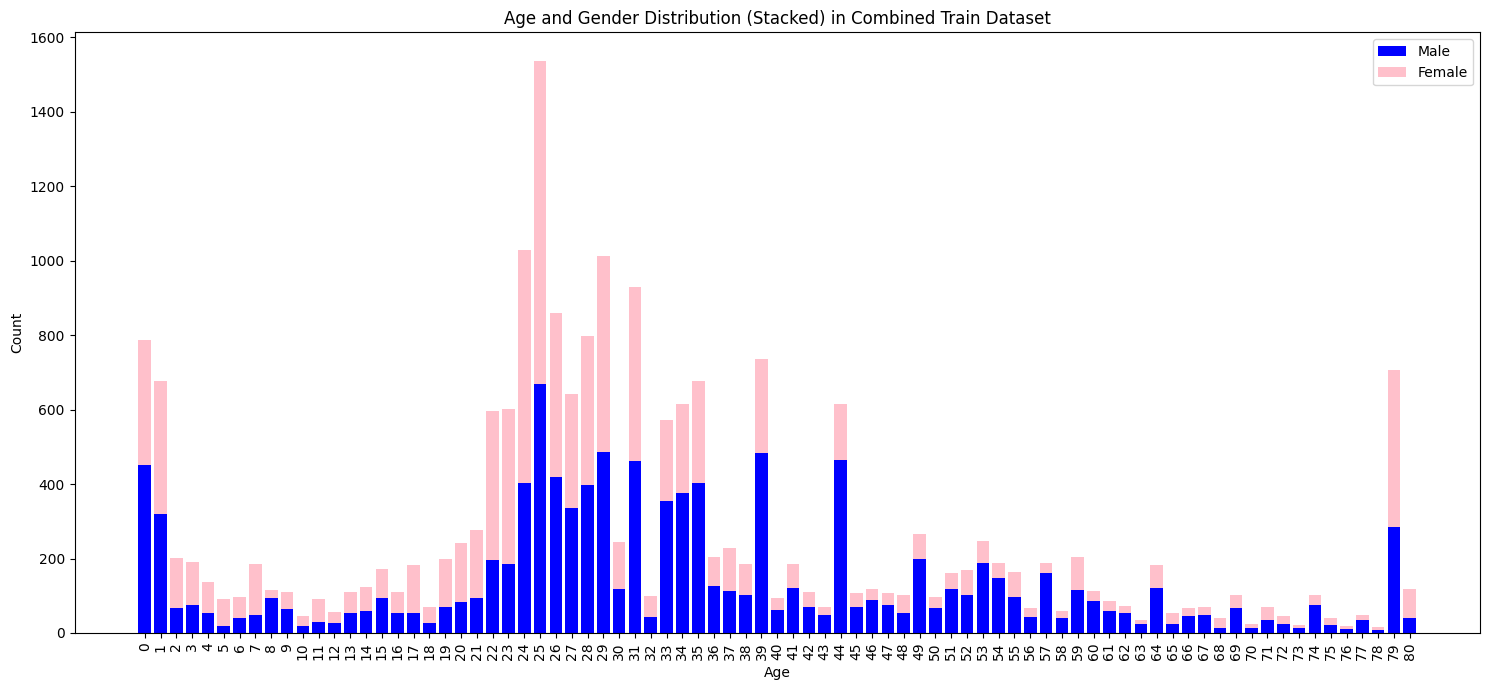

In [59]:
def plot_age_gender_stacked(dataset, title):
    """
    주어진 데이터셋에서 나이에 따른 성별 분포를 스택형 막대 그래프로 시각화합니다.

    Args:
    - dataset: PyTorch Dataset 또는 ConcatDataset
    - title: 그래프 제목
    """
    # 모든 샘플에서 (age, gender) 데이터를 추출
    age_gender = []
    for _, age, gender in dataset:
        age_gender.append((age, gender))

    # 나이별로 남성과 여성의 수를 집계
    age_gender_counter = Counter(age_gender)
    age_labels = sorted(set(age for age, _ in age_gender))
    male_counts = [age_gender_counter[(age, 0)] for age in age_labels]  # 성별 0 (남성)
    female_counts = [age_gender_counter[(age, 1)] for age in age_labels]  # 성별 1 (여성)

    # 그래프 생성
    x = np.arange(len(age_labels))

    plt.figure(figsize=(15, 7))
    plt.bar(x, male_counts, label='Male', color='blue')  # 남성
    plt.bar(x, female_counts, bottom=male_counts, label='Female', color='pink')  # 여성 (남성 위에 쌓음)

    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(x, age_labels, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 학습 데이터셋 분포 (스택형 그래프)
plot_age_gender_stacked(combined_train_dataset1, "Age and Gender Distribution (Stacked) in Combined Train Dataset")

In [60]:
# 특정 레이블을 가진 데이터만 포함하는 AugmentedDataset2 클래스 생성
class AugmentedDataset2(Dataset):
    def __init__(self, dataframe, transform=None):
        # 데이터셋 초기화
        # dataframe: 이미지 경로와 age, gender가 포함된 데이터프레임
        # transform: 이미지에 적용할 전처리(transform) 함수

        # 포함할 나이 리스트
        include_ages = [2, 3, 7, 15, 17, 19, 20, 21, 30, 36, 37, 38, 41, 49, 51, 52, 53, 54, 55, 57, 59, 64]

        self.dataframe = dataframe[dataframe['age'].isin(include_ages)]
        self.transform = transform

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플을 반환
        # 이미지 경로를 데이터프레임에서 가져옴
        img_name = self.dataframe.iloc[idx, 2]
        # 이미지 파일을 열고 RGB 모드로 변환
        img = Image.open(img_name).convert('RGB')
        # age와 gender 정보를 정수형으로 가져옴
        age = int(self.dataframe.iloc[idx, 0])
        gender = int(self.dataframe.iloc[idx, 1])

        # transform이 지정되어 있다면 이미지에 전처리를 적용
        if self.transform:
            img = self.transform(img)

        # 이미지와 age, gender를 반환
        return img, age, gender


# 데이터 증강을 위한 transform 정의
augment_transform2 = transforms.Compose([
    transforms.RandomRotation(10),  # 이미지를 -10도에서 10도 사이로 랜덤 회전
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Lambda(lambda x: x / 255.0)  # 255로 나누어 [0, 1] 범위로 변환
])

augment_transform3 = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=5),
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Lambda(lambda x: x / 255.0)  # 255로 나누어 [0, 1] 범위로 변환
])

# AugmentedDataset 인스턴스 생성 (증강된 학습 데이터셋)
augmented_train_dataset21 = AugmentedDataset2(train_df, transform=augment_transform1)
augmented_train_dataset22 = AugmentedDataset2(train_df, transform=augment_transform2)
augmented_train_dataset23 = AugmentedDataset2(train_df, transform=augment_transform3)
# 기본 학습 데이터셋과 증강된 데이터셋을 결합하여 하나의 데이터셋으로 생성
combined_train_dataset2 = ConcatDataset([combined_train_dataset1, augmented_train_dataset21, augmented_train_dataset22, augmented_train_dataset23])

# 데이터 로더 설정
train_loader = DataLoader(combined_train_dataset2, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

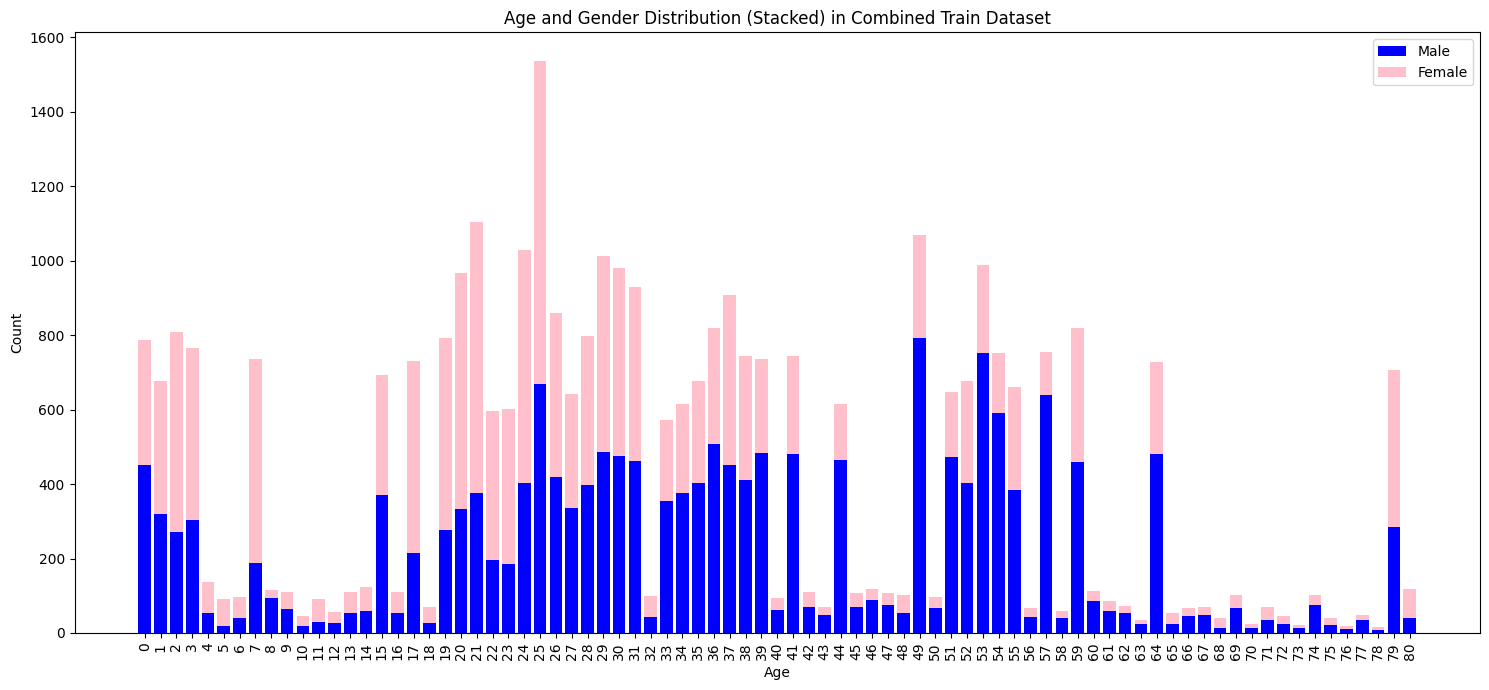

In [61]:
# 학습 데이터셋 분포 (스택형 그래프)
plot_age_gender_stacked(combined_train_dataset2, "Age and Gender Distribution (Stacked) in Combined Train Dataset")

In [62]:
# 특정 레이블을 가진 데이터만 포함하는 AugmentedDataset2 클래스 생성
class AugmentedDataset3(Dataset):
    def __init__(self, dataframe, transform=None):
        # 데이터셋 초기화
        # dataframe: 이미지 경로와 age, gender가 포함된 데이터프레임
        # transform: 이미지에 적용할 전처리(transform) 함수

        # 포함할 나이 리스트
        include_ages = [4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18, 32, 40, 42, 43, 45, 46, 47, 48, 50, 56, 58, 60, 61, 62, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80]

        self.dataframe = dataframe[dataframe['age'].isin(include_ages)]
        self.transform = transform

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플을 반환
        # 이미지 경로를 데이터프레임에서 가져옴
        img_name = self.dataframe.iloc[idx, 2]
        # 이미지 파일을 열고 RGB 모드로 변환
        img = Image.open(img_name).convert('RGB')
        # age와 gender 정보를 정수형으로 가져옴
        age = int(self.dataframe.iloc[idx, 0])
        gender = int(self.dataframe.iloc[idx, 1])

        # transform이 지정되어 있다면 이미지에 전처리를 적용
        if self.transform:
            img = self.transform(img)

        # 이미지와 age, gender를 반환
        return img, age, gender


# 데이터 증강을 위한 transform 정의
augment_transform4 = transforms.Compose([
    transforms.CenterCrop(size=(180, 180)),
    transforms.Resize(size=(200, 200)),
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Lambda(lambda x: x / 255.0)  # 255로 나누어 [0, 1] 범위로 변환
])

augment_transform5 = transforms.Compose([
    transforms.RandomVerticalFlip(),  # 이미지를 수직 방향으로 랜덤 플립
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Lambda(lambda x: x / 255.0)  # 255로 나누어 [0, 1] 범위로 변환
])

augment_transform6 = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 이미지를 수평 방향으로 랜덤 플립
    transforms.RandomVerticalFlip(),  # 이미지를 수직 방향으로 랜덤 플립
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Lambda(lambda x: x / 255.0)  # 255로 나누어 [0, 1] 범위로 변환
])

# AugmentedDataset 인스턴스 생성 (증강된 학습 데이터셋)
augmented_train_dataset31 = AugmentedDataset3(train_df, transform=augment_transform1)
augmented_train_dataset32 = AugmentedDataset3(train_df, transform=augment_transform2)
augmented_train_dataset33 = AugmentedDataset3(train_df, transform=augment_transform3)
augmented_train_dataset34 = AugmentedDataset3(train_df, transform=augment_transform4)
augmented_train_dataset35 = AugmentedDataset3(train_df, transform=augment_transform5)
augmented_train_dataset36 = AugmentedDataset3(train_df, transform=augment_transform6)

# 기본 학습 데이터셋과 증강된 데이터셋을 결합하여 하나의 데이터셋으로 생성
combined_train_dataset3 = ConcatDataset([combined_train_dataset2, augmented_train_dataset31, augmented_train_dataset32, augmented_train_dataset33, augmented_train_dataset34, augmented_train_dataset35, augmented_train_dataset36])

# 데이터 로더 설정
train_loader = DataLoader(combined_train_dataset3, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

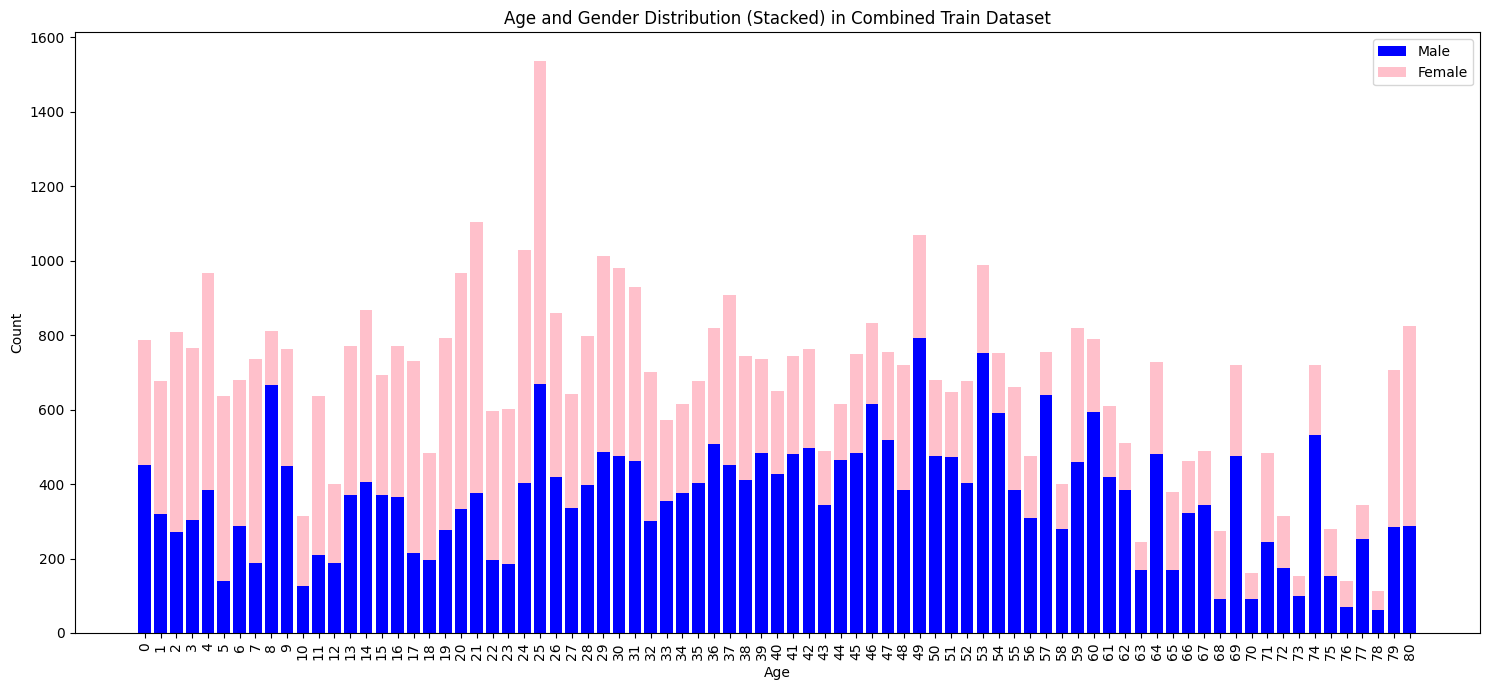

In [63]:
# 학습 데이터셋 분포 (스택형 그래프)
plot_age_gender_stacked(combined_train_dataset3, "Age and Gender Distribution (Stacked) in Combined Train Dataset")

In [ ]:
num_epochs = 50
best_val_acc = 0.0
patience = 5
no_improve = 0

train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_gender_train = 0
    correct_age_train_top3 = 0
    total_train = 0

    for inputs, ages, genders in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        inputs, ages, genders = inputs.to(device), ages.to(device), genders.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        gender_logits = model.gender_output(outputs)
        age_logits = model.age_output(outputs)

        loss_gender = criterion_gender(gender_logits, genders)
        loss_age = criterion_age(age_logits, ages)
        loss = loss_gender + loss_age

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted_gender = torch.max(gender_logits, 1)
        correct_gender_train += (predicted_gender == genders).sum().item()

        _, predicted_age_top3 = torch.topk(age_logits, k=3, dim=1)
        correct_age_train_top3 += sum([ages[i] in predicted_age_top3[i] for i in range(len(ages))])
        total_train += ages.size(0)

    avg_loss = running_loss / len(train_loader)
    train_acc_gender = correct_gender_train / total_train
    train_acc_age_top3 = correct_age_train_top3 / total_train

    model.eval()
    correct_gender_val = 0
    correct_age_val_top3 = 0
    total_val = 0
    running_val_loss = 0.0

    with torch.no_grad():
        for inputs, ages, genders in valid_loader:
            inputs, ages, genders = inputs.to(device), ages.to(device), genders.to(device)

            outputs = model(inputs)
            gender_logits = model.gender_output(outputs)
            age_logits = model.age_output(outputs)

            loss_gender = criterion_gender(gender_logits, genders)
            loss_age = criterion_age(age_logits, ages)
            val_loss = loss_gender + loss_age
            running_val_loss += val_loss.item()

            _, predicted_gender = torch.max(gender_logits, 1)
            correct_gender_val += (predicted_gender == genders).sum().item()

            _, predicted_age_top3 = torch.topk(age_logits, k=3, dim=1)
            correct_age_val_top3 += sum([ages[i] in predicted_age_top3[i] for i in range(len(ages))])
            total_val += ages.size(0)

    avg_val_loss = running_val_loss / len(valid_loader)
    val_acc_gender = correct_gender_val / total_val
    val_acc_age_top3 = correct_age_val_top3 / total_val

    train_losses.append(avg_loss)
    valid_losses.append(avg_val_loss)

    train_accs.append(train_acc_age_top3)
    valid_accs.append(val_acc_age_top3)

    print(f"Epoch [{epoch+1}/{num_epochs}]:")
    print(f"  Train Loss: {avg_loss:.4f}, Train Gender Acc: {train_acc_gender:.4f}, Train Age Top-3 Acc: {train_acc_age_top3:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Gender Acc: {val_acc_gender:.4f}, Val Age Top-3 Acc: {val_acc_age_top3:.4f}")

    if val_acc_age_top3 > best_val_acc:
        best_val_acc = val_acc_age_top3
        torch.save(model.state_dict(), 'best_model.pth') # add
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [1/50]:
  Train Loss: 3.7655, Train Gender Acc: 0.9330, Train Age Top-3 Acc: 0.2607
  Val Loss: 3.4497, Val Gender Acc: 0.9253, Val Age Top-3 Acc: 0.3254


Epoch 2/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [2/50]:
  Train Loss: 3.5816, Train Gender Acc: 0.9468, Train Age Top-3 Acc: 0.2975
  Val Loss: 3.3478, Val Gender Acc: 0.9386, Val Age Top-3 Acc: 0.3408


Epoch 3/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [3/50]:
  Train Loss: 3.4762, Train Gender Acc: 0.9538, Train Age Top-3 Acc: 0.3190
  Val Loss: 3.2992, Val Gender Acc: 0.9378, Val Age Top-3 Acc: 0.3456


Epoch 4/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [4/50]:
  Train Loss: 3.3812, Train Gender Acc: 0.9593, Train Age Top-3 Acc: 0.3386
  Val Loss: 3.2318, Val Gender Acc: 0.9431, Val Age Top-3 Acc: 0.3667


Epoch 5/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [5/50]:
  Train Loss: 3.2898, Train Gender Acc: 0.9615, Train Age Top-3 Acc: 0.3615
  Val Loss: 3.1904, Val Gender Acc: 0.9458, Val Age Top-3 Acc: 0.3749


Epoch 6/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [6/50]:
  Train Loss: 3.2086, Train Gender Acc: 0.9658, Train Age Top-3 Acc: 0.3806
  Val Loss: 3.1426, Val Gender Acc: 0.9479, Val Age Top-3 Acc: 0.3870


Epoch 7/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [7/50]:
  Train Loss: 3.1231, Train Gender Acc: 0.9678, Train Age Top-3 Acc: 0.4016
  Val Loss: 3.1149, Val Gender Acc: 0.9509, Val Age Top-3 Acc: 0.4043


Epoch 8/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [8/50]:
  Train Loss: 3.0467, Train Gender Acc: 0.9692, Train Age Top-3 Acc: 0.4234
  Val Loss: 3.0807, Val Gender Acc: 0.9488, Val Age Top-3 Acc: 0.4167


Epoch 9/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [9/50]:
  Train Loss: 2.9686, Train Gender Acc: 0.9700, Train Age Top-3 Acc: 0.4452
  Val Loss: 3.0182, Val Gender Acc: 0.9519, Val Age Top-3 Acc: 0.4315


Epoch 10/50: 100%|██████████| 427/427 [02:44<00:00,  2.60it/s]


Epoch [10/50]:
  Train Loss: 2.8895, Train Gender Acc: 0.9723, Train Age Top-3 Acc: 0.4634
  Val Loss: 3.0176, Val Gender Acc: 0.9509, Val Age Top-3 Acc: 0.4460


Epoch 11/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [11/50]:
  Train Loss: 2.8166, Train Gender Acc: 0.9737, Train Age Top-3 Acc: 0.4849
  Val Loss: 2.9568, Val Gender Acc: 0.9526, Val Age Top-3 Acc: 0.4642


Epoch 12/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [12/50]:
  Train Loss: 2.7252, Train Gender Acc: 0.9752, Train Age Top-3 Acc: 0.5118
  Val Loss: 2.9316, Val Gender Acc: 0.9536, Val Age Top-3 Acc: 0.4749


Epoch 13/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [13/50]:
  Train Loss: 2.6490, Train Gender Acc: 0.9745, Train Age Top-3 Acc: 0.5340
  Val Loss: 2.8951, Val Gender Acc: 0.9530, Val Age Top-3 Acc: 0.4905


Epoch 14/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [14/50]:
  Train Loss: 2.5719, Train Gender Acc: 0.9759, Train Age Top-3 Acc: 0.5522
  Val Loss: 2.8840, Val Gender Acc: 0.9534, Val Age Top-3 Acc: 0.5063


Epoch 15/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [15/50]:
  Train Loss: 2.4883, Train Gender Acc: 0.9761, Train Age Top-3 Acc: 0.5767
  Val Loss: 2.8150, Val Gender Acc: 0.9542, Val Age Top-3 Acc: 0.5186


Epoch 16/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [16/50]:
  Train Loss: 2.4152, Train Gender Acc: 0.9760, Train Age Top-3 Acc: 0.5945
  Val Loss: 2.7704, Val Gender Acc: 0.9536, Val Age Top-3 Acc: 0.5375


Epoch 17/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [17/50]:
  Train Loss: 2.3370, Train Gender Acc: 0.9762, Train Age Top-3 Acc: 0.6148
  Val Loss: 2.7682, Val Gender Acc: 0.9536, Val Age Top-3 Acc: 0.5458


Epoch 18/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [18/50]:
  Train Loss: 2.2656, Train Gender Acc: 0.9773, Train Age Top-3 Acc: 0.6343
  Val Loss: 2.7104, Val Gender Acc: 0.9532, Val Age Top-3 Acc: 0.5586


Epoch 19/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [19/50]:
  Train Loss: 2.1833, Train Gender Acc: 0.9772, Train Age Top-3 Acc: 0.6561
  Val Loss: 2.6791, Val Gender Acc: 0.9528, Val Age Top-3 Acc: 0.5685


Epoch 20/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [20/50]:
  Train Loss: 2.1147, Train Gender Acc: 0.9765, Train Age Top-3 Acc: 0.6732
  Val Loss: 2.6545, Val Gender Acc: 0.9526, Val Age Top-3 Acc: 0.5818


Epoch 21/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [21/50]:
  Train Loss: 2.0358, Train Gender Acc: 0.9768, Train Age Top-3 Acc: 0.6910
  Val Loss: 2.6118, Val Gender Acc: 0.9532, Val Age Top-3 Acc: 0.5960


Epoch 22/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [22/50]:
  Train Loss: 1.9657, Train Gender Acc: 0.9780, Train Age Top-3 Acc: 0.7054
  Val Loss: 2.5993, Val Gender Acc: 0.9519, Val Age Top-3 Acc: 0.5993


Epoch 23/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [23/50]:
  Train Loss: 1.8981, Train Gender Acc: 0.9779, Train Age Top-3 Acc: 0.7188
  Val Loss: 2.5896, Val Gender Acc: 0.9528, Val Age Top-3 Acc: 0.6038


Epoch 24/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [24/50]:
  Train Loss: 1.8262, Train Gender Acc: 0.9795, Train Age Top-3 Acc: 0.7414
  Val Loss: 2.5177, Val Gender Acc: 0.9523, Val Age Top-3 Acc: 0.6151


Epoch 25/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [25/50]:
  Train Loss: 1.7638, Train Gender Acc: 0.9778, Train Age Top-3 Acc: 0.7500
  Val Loss: 2.5041, Val Gender Acc: 0.9534, Val Age Top-3 Acc: 0.6274


Epoch 26/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [26/50]:
  Train Loss: 1.6945, Train Gender Acc: 0.9787, Train Age Top-3 Acc: 0.7637
  Val Loss: 2.5022, Val Gender Acc: 0.9511, Val Age Top-3 Acc: 0.6293


Epoch 27/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [27/50]:
  Train Loss: 1.6301, Train Gender Acc: 0.9785, Train Age Top-3 Acc: 0.7778
  Val Loss: 2.4595, Val Gender Acc: 0.9517, Val Age Top-3 Acc: 0.6329


Epoch 28/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [28/50]:
  Train Loss: 1.5762, Train Gender Acc: 0.9785, Train Age Top-3 Acc: 0.7891
  Val Loss: 2.4542, Val Gender Acc: 0.9517, Val Age Top-3 Acc: 0.6394


Epoch 29/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [29/50]:
  Train Loss: 1.5128, Train Gender Acc: 0.9790, Train Age Top-3 Acc: 0.8015
  Val Loss: 2.4570, Val Gender Acc: 0.9500, Val Age Top-3 Acc: 0.6385


Epoch 30/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [30/50]:
  Train Loss: 1.4550, Train Gender Acc: 0.9795, Train Age Top-3 Acc: 0.8154
  Val Loss: 2.4087, Val Gender Acc: 0.9507, Val Age Top-3 Acc: 0.6445


Epoch 31/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [31/50]:
  Train Loss: 1.3979, Train Gender Acc: 0.9794, Train Age Top-3 Acc: 0.8251
  Val Loss: 2.3996, Val Gender Acc: 0.9513, Val Age Top-3 Acc: 0.6495


Epoch 32/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [32/50]:
  Train Loss: 1.3489, Train Gender Acc: 0.9793, Train Age Top-3 Acc: 0.8341
  Val Loss: 2.3559, Val Gender Acc: 0.9526, Val Age Top-3 Acc: 0.6554


Epoch 33/50:  10%|▉         | 42/427 [00:16<02:28,  2.60it/s]

## Loss, Top-3 Accuracy 시각화

In [ ]:
epochs = range(1, len(train_losses) + 1)

# 그래프 생성
plt.figure(figsize=(14, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color="blue")
plt.plot(epochs, valid_losses, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.grid(True)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Top-3 Accuracy", color="blue")
plt.plot(epochs, valid_accs, label="Validation Top-3 Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Top-3 Accuracy")
plt.title("Train and Validation Top-3 Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Best Model

In [32]:
model.load_state_dict(torch.load('best_model.pth'))
model = model.to('cuda')

<ipython-input-32-5c292473c2ee>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_before (1).pth'))
